In [1]:
import importlib
import shiftNMF_frozen
importlib.reload(shiftNMF_frozen)
from shiftNMF_frozen import ShiftNMF
from nnls_l1 import nnls
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from helpers.generators import *
from helpers.data import X_WINE, PPM_WINE
import Hardmodel_single_peaks
importlib.reload(Hardmodel_single_peaks)
from Hardmodel_single_peaks import Single_Model
from Hardmodel import Hard_Model
import scipy
from scipy.signal import find_peaks
import itertools

import helpers.fit_functions 
importlib.reload(helpers.fit_functions)
from helpers.fit_functions import *

# shiftNMF

[5.99978451 5.99915313 5.99852176 ... 0.50114961 0.50051823 0.49988686]
3.758407321767532
3.474289087241136


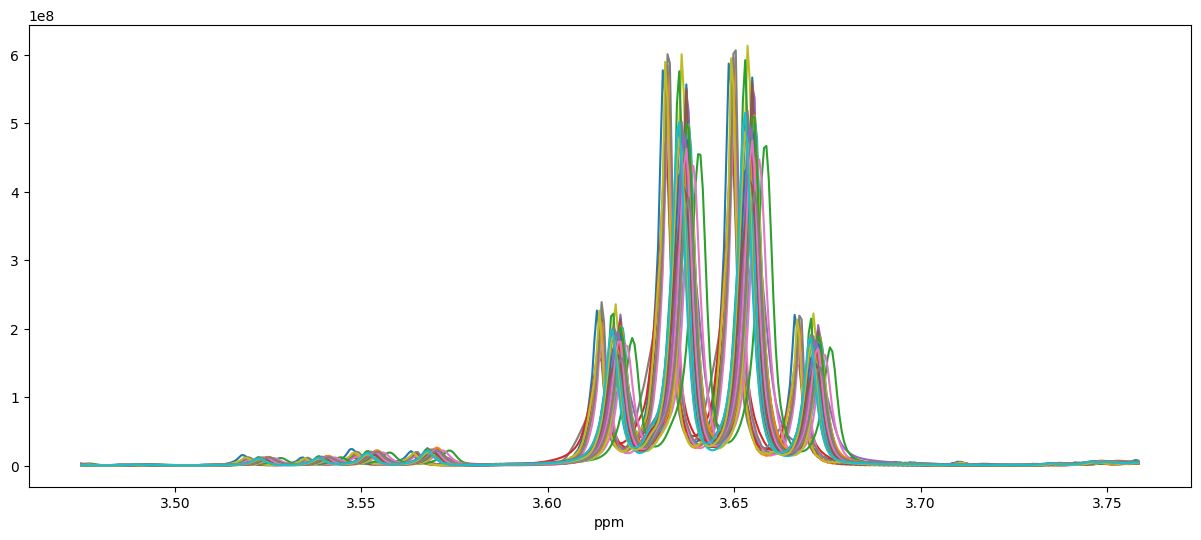

In [16]:
# 3.5-3.7
si = 3550
ei = 4000
#3.5-3.6
# si = 3800
# ei = 4000
#

print(PPM_WINE)
X = X_WINE[:,si:ei]
print(PPM_WINE[si])
print(PPM_WINE[ei])
ppm = PPM_WINE[si:ei]
plt.figure(figsize=(15,6))
plt.plot(ppm,X.T)
plt.xlabel("ppm")
plt.show()

epoch: 1000, Loss: 0.015838662669611113, Tau: 714.4298426017771


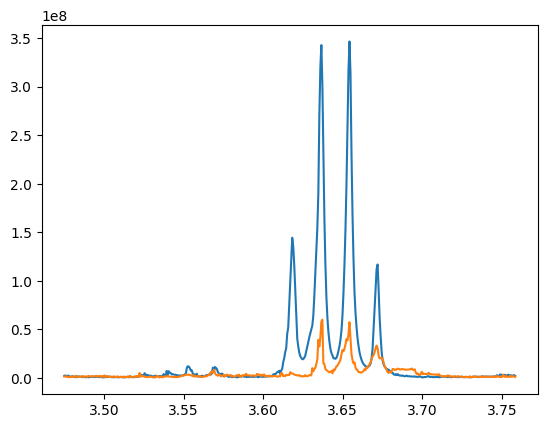

In [17]:

nmf = ShiftNMF(X, 2, lr=0.1, alpha=1e-6, min_imp=0.001)
W_est, H_est, tau_est = nmf.fit(verbose=1, max_iter=1000, tau_iter=0, Lambda=0.000)
plt.plot(ppm,H_est.T)
plt.show()


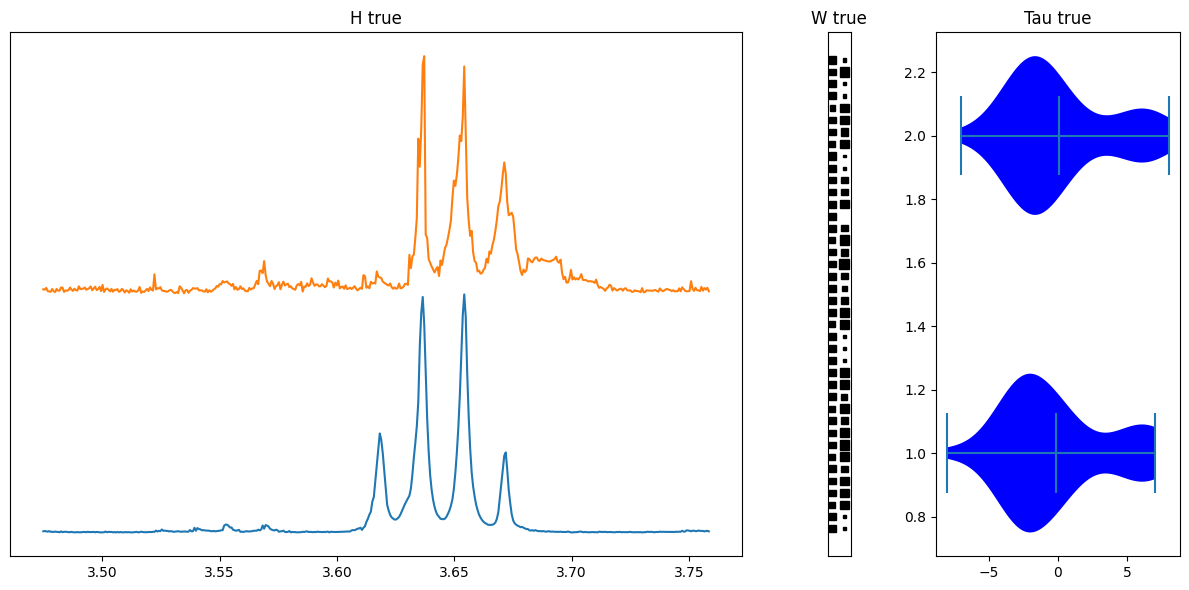

In [18]:
from helpers.plot import *
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

fig = plt.figure(figsize=(12, 6))
N, M = X[:,0:3000].shape
H_scaled = np.zeros_like(H_est)
for i, vec in enumerate(H_est):
    H_scaled[i] = vec/max(vec)

# Plot H and H_est
ax1 = plt.subplot(gs[0])
plotSpaced(ax1, ppm, H_scaled.T)
ax1.set_title('H true')

ax2 = plt.subplot(gs[1])
ax2.set_title('W true')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau true')
change_violin_colors(violin_parts, color_list=['blue']*N)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# Set tight layout
plt.tight_layout()
plt.show()

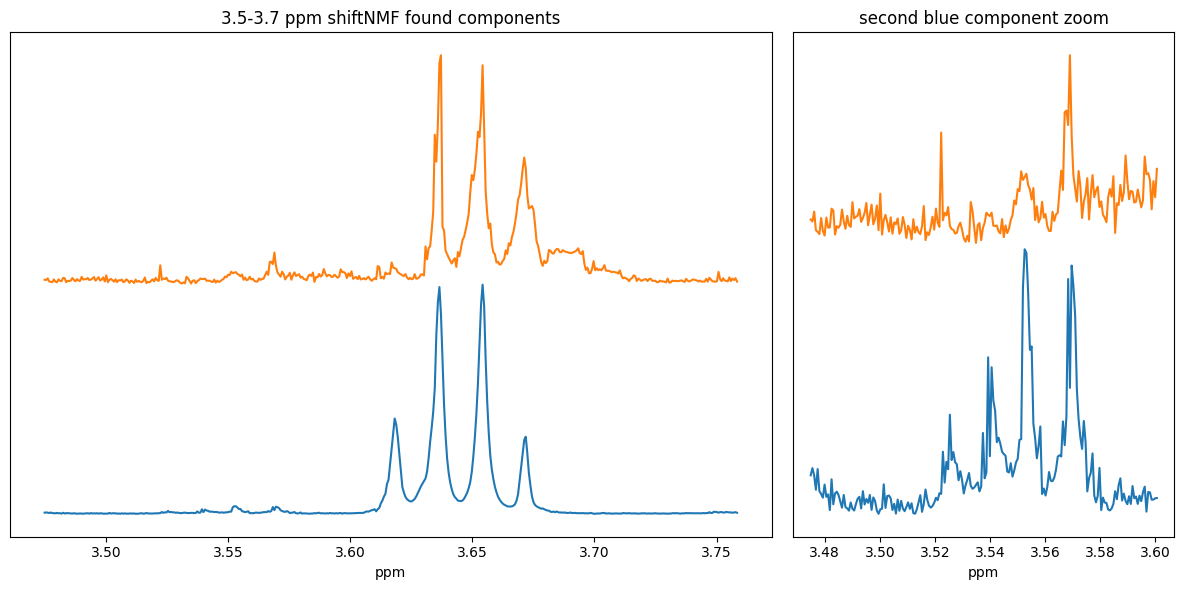

In [34]:
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

fig = plt.figure(figsize=(12, 6))
H_scaled = np.zeros_like(H_est)
for i, vec in enumerate(H_est):
    H_scaled[i] = vec/max(vec)

# Plot H and H_est
ax1 = plt.subplot(gs[0])
plotSpaced(ax1, ppm, H_scaled.T)
ax1.set_title('3.5-3.7 ppm shiftNMF found components')
ax1.set_xlabel("ppm")

ax2 = plt.subplot(gs[1])
ax2.set_title('3.5-3.5 ppm zoom')
plotSpaced(ax2, ppm[250:],H_est[:,250:].T)
ax2.set_xlabel("ppm")


# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# Set tight layout
plt.tight_layout()
plt.show()


# Hardmodel

TypeError: single_fit() got an unexpected keyword argument 'plot'

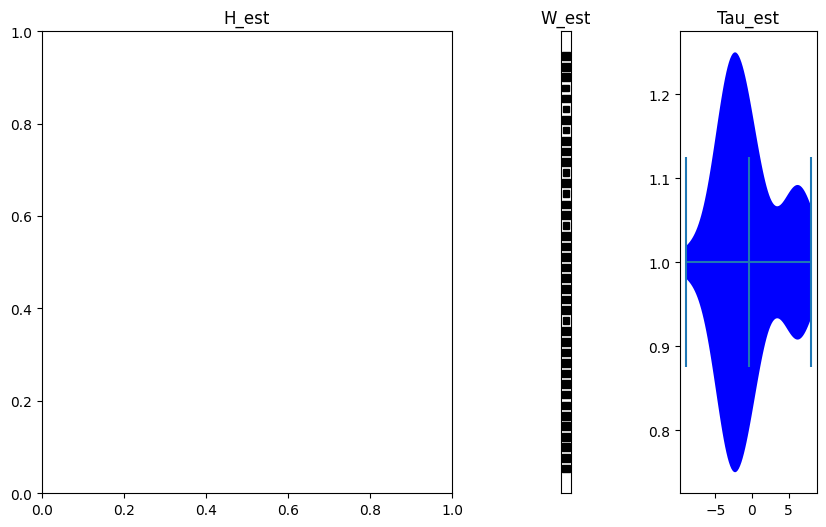

In [8]:

fig = plt.figure(figsize=(10, 6))
# Create a gridspec object with 2 rows and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

# Plot H and H_est
ax1 = plt.subplot(gs[0])
# plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
ax1.set_title('H_est')
x = np.arange(H_est.shape[1])

ax2 = plt.subplot(gs[1])
ax2.set_title('W_est')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau_est')
change_violin_colors(violin_parts, color_list=['blue']*3)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# plt.figure(figsize=(15,5))
# plt.plot(H_est.T)
# plt.savefig("shiftcomponents")
# plt.clf()
ymax = 0
for i in range(len(H_est)):
    ymax = max(ymax,(H_est[i]/np.std(H_est[i])).max())
yoffset = ymax
reg_paths = []
lambda_axis = []
C_path = []

for i in range(len(H_est)):
    means, sigmas, n = single_fit(H_est[i], min_height=0.5, min_sigma=1, lr=0.1 , plot=True)
    #diff_matrix = calc_difference_matrix(sigmas)
    print("HERER ARE THE SINGLE FITS SIGMAS")
    print(sigmas)
    diff_matrix = calc_difference_matrix(np.ones((len(sigmas))))
    hypothesis = peak_hypothesis(diff_matrix, cutoff=10/100)
    hardmodel = Hard_Model(H_est[i], hypothesis, means, sigmas, n, lr=10, alpha = 1e-3, factor=1, patience=1, min_imp=0.01)

    W, C, running_loss, path, lambdas = hardmodel.fit(verbose=True, return_loss=True, threshold=0.5)
    reg_paths.append(path)
    lambda_axis.append(lambdas)
    C_path.append(C)
    means, sigma, j_coup, mult, n = hardmodel.return_values()
    print("means:")
    print(means)
    print("sigmas:")
    print(sigma)
    print("J coupling:")
    print(j_coup)
    print("multiplicity")
    print(mult)
    print("N")
    print(n)

    print("W:")
    print(W)
    ## TODO change this to be the true underlying components from H_ART not the shift found components, they need to be scaled accordingly.
    # plt.figure(figsize=(15,5))
    # plt.plot(H_est[i]/np.std(H_est[i]), linewidth=5, color="k")
    ax1.plot(x,H_est[i]/np.std(H_est[i])+yoffset*i, linewidth=4, color="k")
    for j, vec in enumerate(C):
        ax1.plot(x,vec*W[:,j]+yoffset*i)
# Set tight layout
plt.tight_layout()
plt.show()

[ 2.46550854e+01  8.04307069e+00  4.21218839e+00  1.73544818e+00
  9.96639345e-01  2.80797513e-01  1.47259532e-01  1.34073394e-01
  9.80876357e-02  6.34547129e-02  4.14072560e-02  1.44893330e-02
  1.21466314e-02  9.51834677e-03 -6.38505479e-03]
0.0


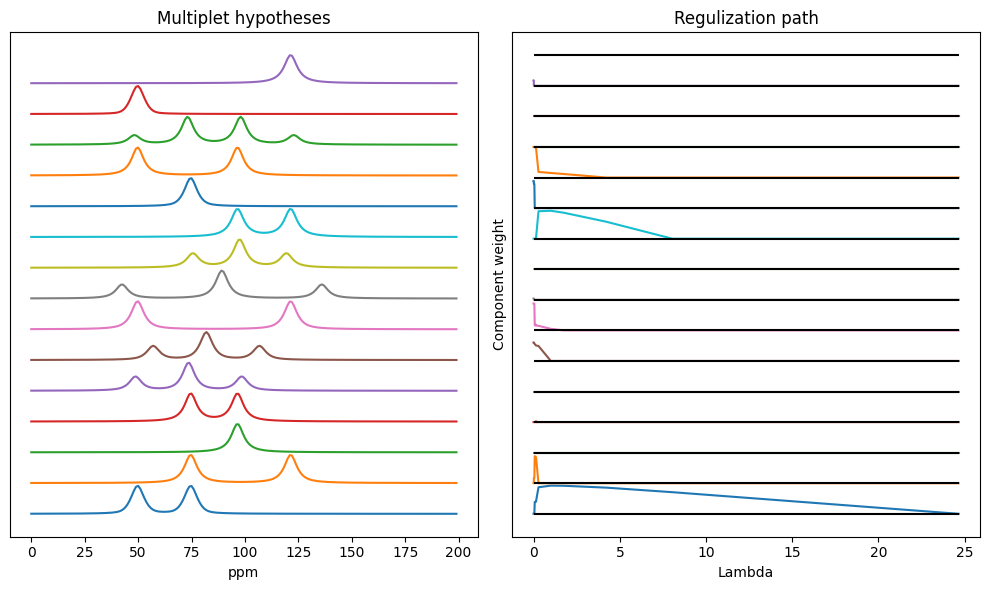

In [6]:
for i in range(len(reg_paths)):
    path = reg_paths[i]
    lambdas = lambda_axis[i]
    print(lambdas[0])
    C = C_path[i]


    fig = plt.figure(figsize=(10, 6))
    # Create a gridspec object with 2 rows and 3 columns
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    # Plot H and H_est
    ax1 = plt.subplot(gs[0])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax1.set_title('Multiplet hypotheses')

    ax1.set_xlabel("ppm")
   
    x = np.arange(H_est.shape[1])

    ax2 = plt.subplot(gs[1])
    ax2.set_title('Regulization path')
    ax2.set_xlabel("Lambda")
    ax2.set_ylabel("Component weight")

    ax1.tick_params(left = False, labelleft = False)
    ax2.tick_params(left = False, labelleft = False)

    ymax = 1.1
    # for j, vec in enumerate(C):
    #     ymax = max(ymax,(C[j]/max(C[j])).max())

    cutoff = [0]

    yoffset = ymax
    t = 0
    for j, vec in enumerate(C):
        if any(path[0][j] >= cutoff[i]):
            ax1.plot(x,vec/max(vec)+yoffset*t)
            t += 1
    print(path[0].min())
    
    ymax = path[0].max()
    yoffset = ymax
    t = 0
    for j, vec in enumerate(C):
        if any(path[0][j] >= cutoff[i]):
            ax2.plot(lambdas[0],path[0][j]+yoffset*t, scalex='log')
            ax2.hlines(yoffset*t,lambdas[0][-1],lambdas[0][0], color="k")
            t +=1
    ax2.hlines(yoffset*t,lambdas[0][-1],lambdas[0][0], color="k")

    #plt.title("Hardmodelled component regulization path")
    #plt.plot(lambdas[0], reg_paths[i][0].T)
    # plt.savefig("fig"+str(i)+"_path")
    plt.tight_layout()
    plt.show()